cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.39e+00 | test_loss: 7.74e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:02<00:00, 40.02


saving model version 0.1
MAE: 6.1085
MSE: 59.8668
MAPE: 6.2169
R²: 0.7626
RMSE: 7.7374
fixing (0,0,0) with sin, r2=1.0000004768371582, c=2
fixing (0,1,0) with log10, r2=0.9999442100524902, c=1
fixing (0,2,0) with log10, r2=0.9788291454315186, c=1
fixing (0,3,0) with cos, r2=1.0000004768371582, c=2
saving model version 0.2


52.026*log10(2.408*x_2 + 8.63) + 41.516*log10(0.383*x_3 + 4.03) + 4.912*sin(8.226*x_1 - 2.854) - 1.328*cos(5.036*x_4 - 0.448) - 11.236

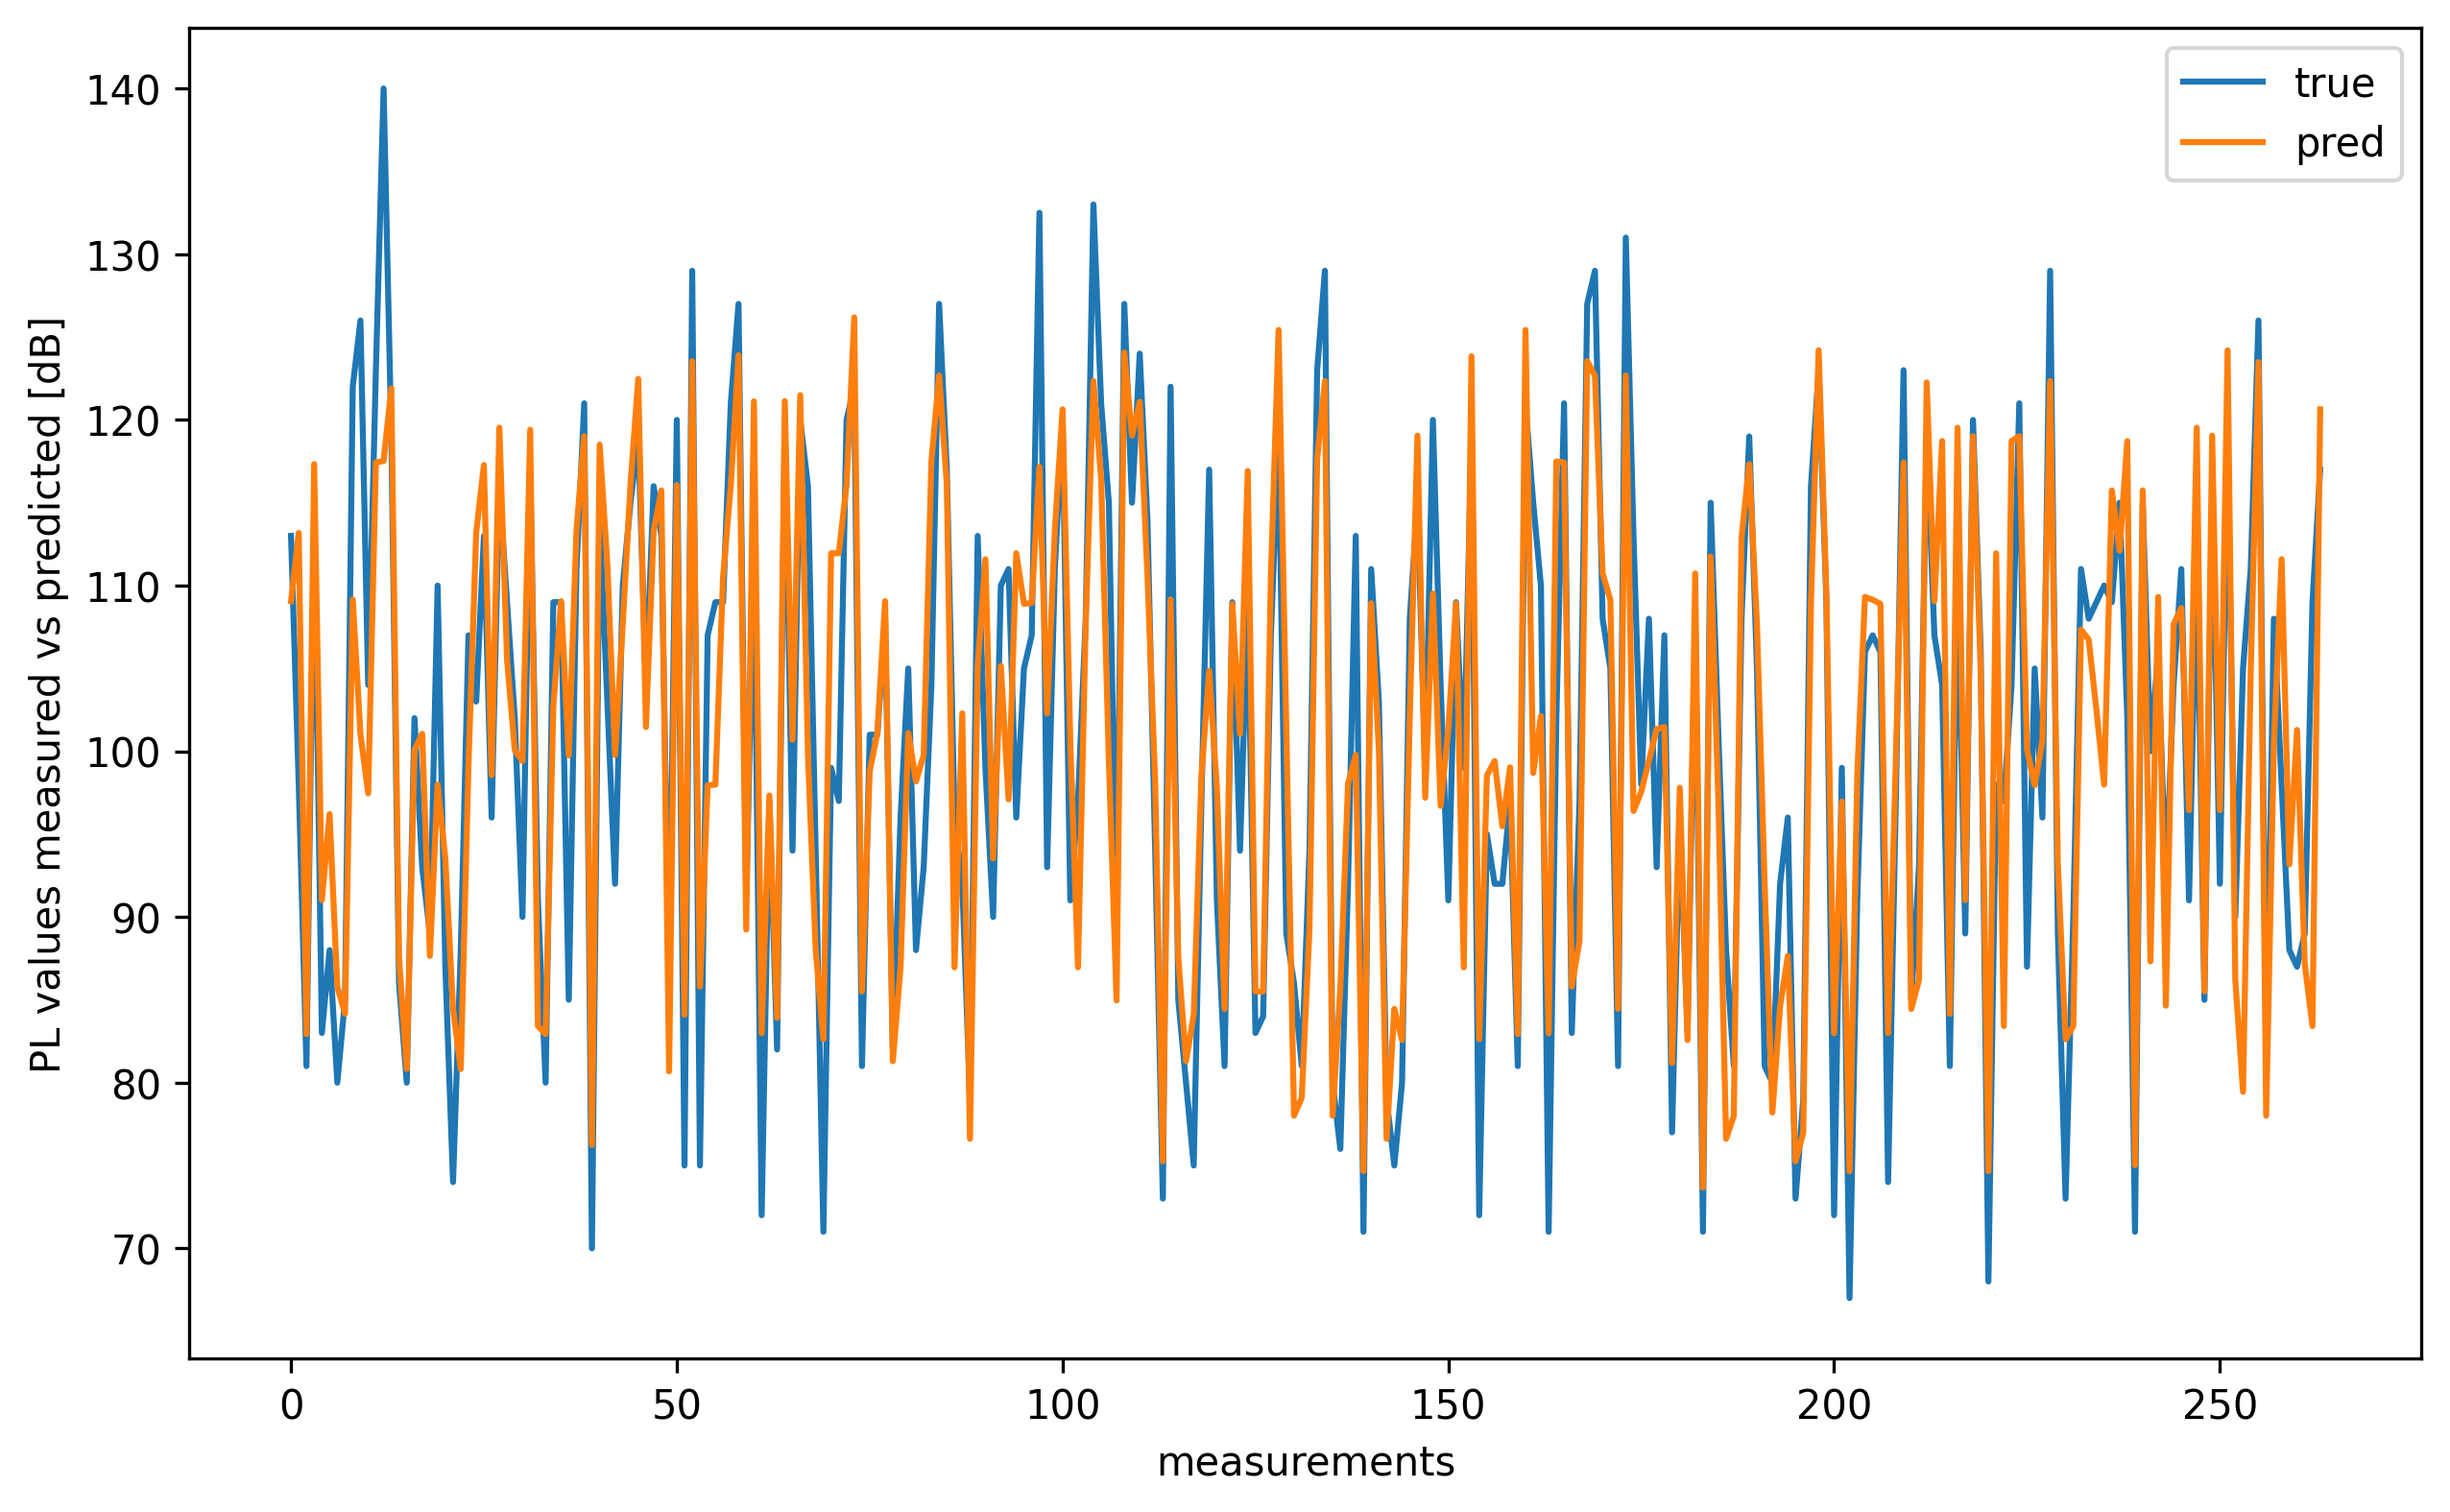

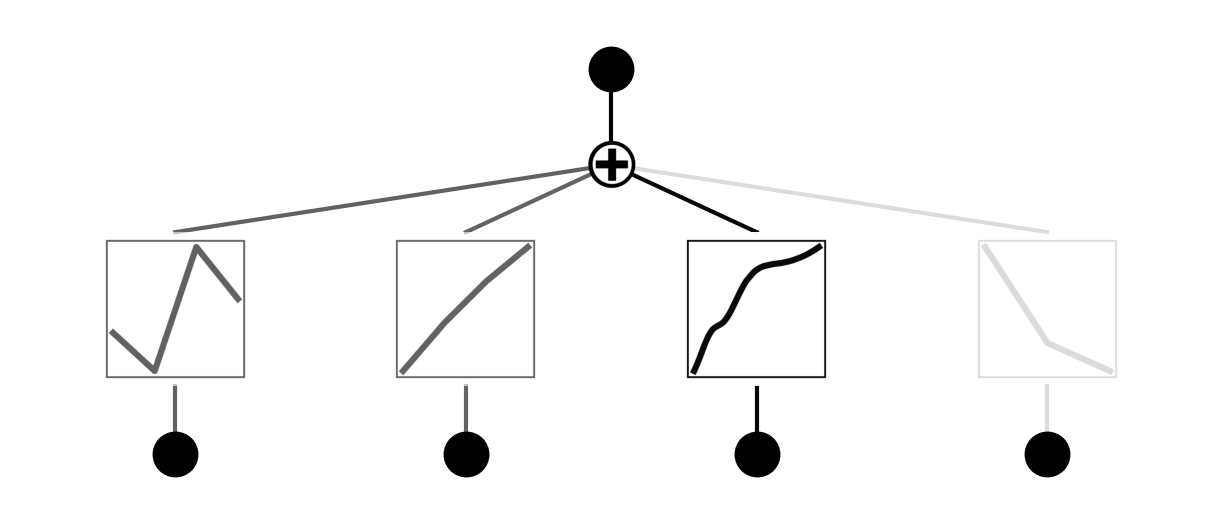

In [1]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Indoor', header=0)

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = indoor_data[['nw', 'nf', 'd', 'f']].values  # Input features (f and d)
labels = indoor_data['PL'].values    # Output labels 
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {}
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

model = KAN(width=[4,1], grid=5, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.0002, lamb_entropy=2.);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)



MAE: 6.2668
MSE: 61.6216
MAPE: 6.3761
R²: 0.7556
RMSE: 7.8499


/var/folders/kp/ywhxwl8j55z_9fb901tc6x_w0000gp/T/ipykernel_21446/795080839.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: 52.026 * np.log10(2.408 * x[:, 1] + 8.63) + 41.516 * np.log10(0.383 * x[:, 2] + 4.03) + 4.912 * np.sin(8.226 * x[:, 0] - 2.854) - 1.328 * np.cos(5.036 * x[:, 3] - 0.448) - 11.236


(61.62157440185547,
 np.float64(7.849941044482785),
 6.266800403594971,
 6.376068294048309,
 0.7555981874465942)

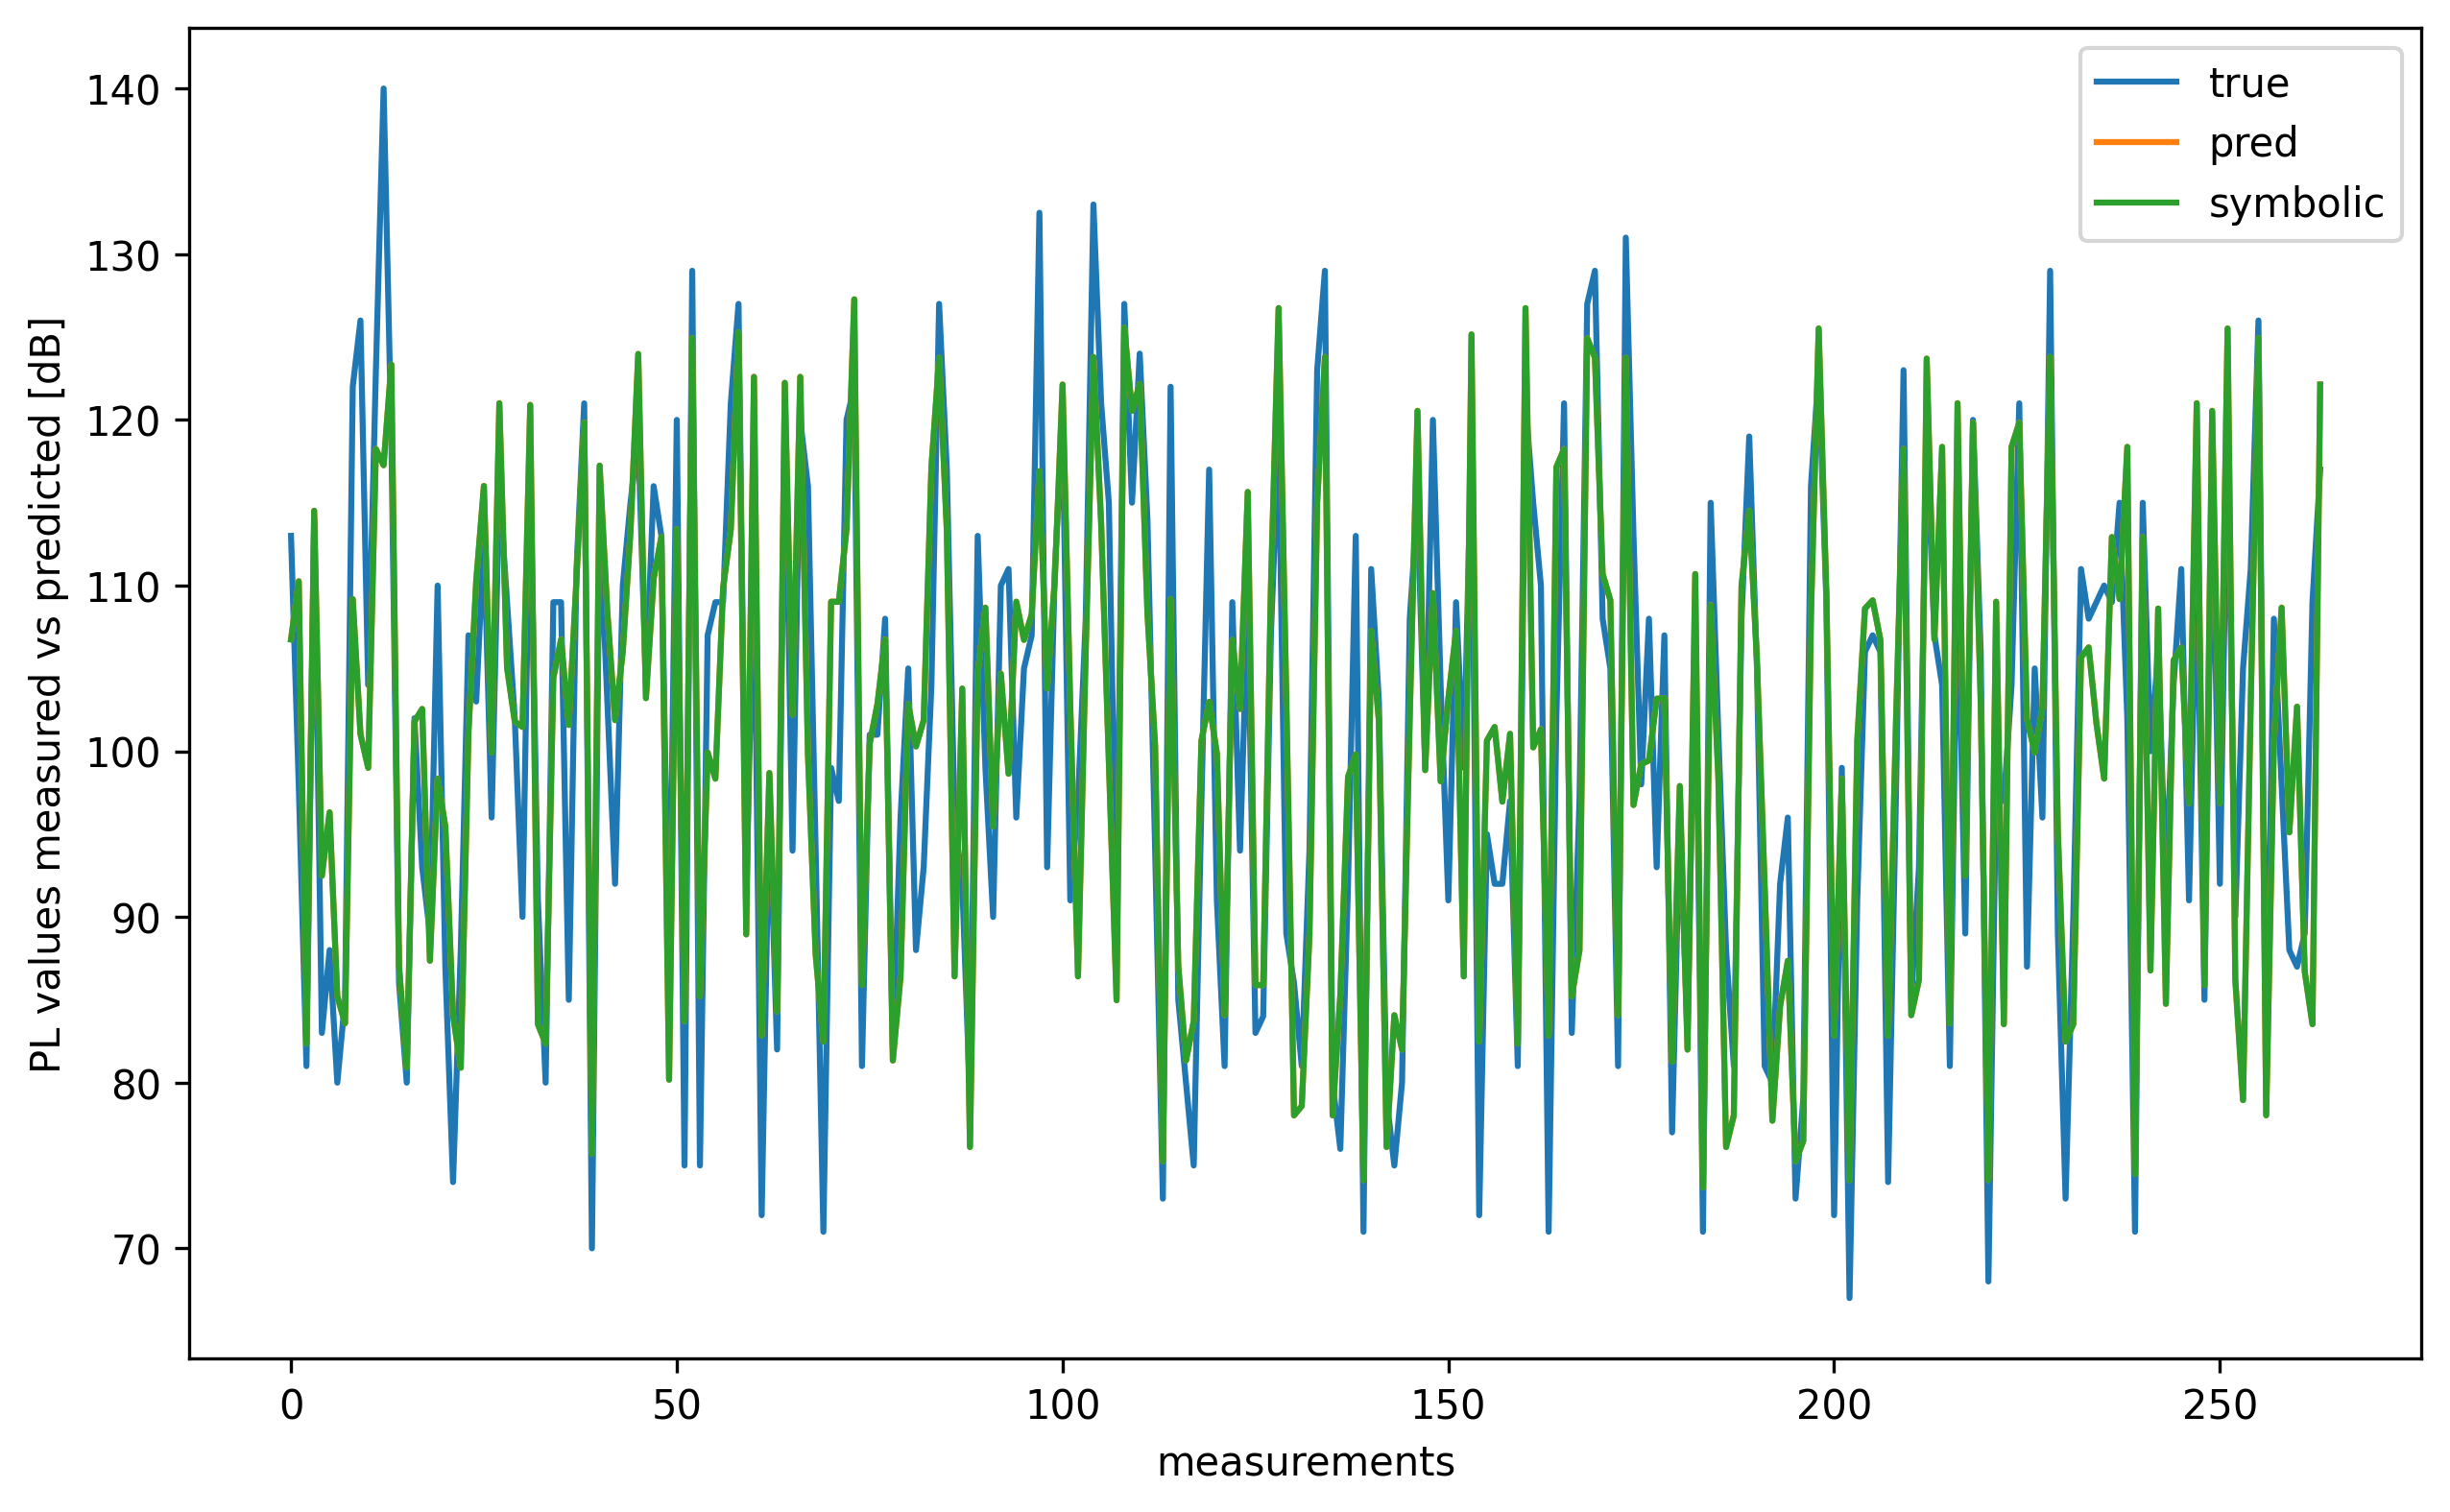

In [2]:

f = lambda x: 52.026 * np.log10(2.408 * x[:, 1] + 8.63) + 41.516 * np.log10(0.383 * x[:, 2] + 4.03) + 4.912 * np.sin(8.226 * x[:, 0] - 2.854) - 1.328 * np.cos(5.036 * x[:, 3] - 0.448) - 11.236

eval_kan(model, f, dataset)




checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 7.38e+00 | test_loss: 7.73e+00 | reg: 1.36e+01 | : 100%|█| 100/100 [00:02<00:00, 44.96


saving model version 0.1
MAE: 6.1115
MSE: 59.7628
MAPE: 6.2202
R²: 0.7630
RMSE: 7.7306
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 7.38e+00 | test_loss: 7.73e+00 | reg: 1.35e+01 | : 100%|█| 100/100 [00:02<00:00, 47.47


saving model version 0.1
MAE: 6.1091
MSE: 59.7849
MAPE: 6.2111
R²: 0.7629
RMSE: 7.7321
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 7.39e+00 | test_loss: 7.74e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:02<00:00, 48.36


saving model version 0.1
MAE: 6.1085
MSE: 59.8668
MAPE: 6.2169
R²: 0.7626
RMSE: 7.7374
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 7.38e+00 | test_loss: 7.74e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:02<00:00, 42.17


saving model version 0.1
MAE: 6.0977
MSE: 59.8855
MAPE: 6.2008
R²: 0.7625
RMSE: 7.7386
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 7.37e+00 | test_loss: 7.71e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:04<00:00, 49.54


saving model version 0.1
MAE: 6.0812
MSE: 59.4301
MAPE: 6.1895
R²: 0.7643
RMSE: 7.7091
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 7.37e+00 | test_loss: 7.68e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:03<00:00, 53.24


saving model version 0.1
MAE: 6.0439
MSE: 59.0513
MAPE: 6.1435
R²: 0.7658
RMSE: 7.6845
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 7.39e+00 | test_loss: 7.74e+00 | reg: 1.37e+01 | : 100%|█| 200/200 [00:03<00:00, 56.64


saving model version 0.1
MAE: 6.1166
MSE: 59.8516
MAPE: 6.2253
R²: 0.7626
RMSE: 7.7364
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 7.37e+00 | test_loss: 7.68e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:04<00:00, 47.18


saving model version 0.1
MAE: 6.0449
MSE: 59.0410
MAPE: 6.1444
R²: 0.7658
RMSE: 7.6838
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 7.37e+00 | test_loss: 7.70e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 52.39


saving model version 0.1
MAE: 6.0570
MSE: 59.2209
MAPE: 6.1587
R²: 0.7651
RMSE: 7.6955
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 7.37e+00 | test_loss: 7.68e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:04<00:00, 61.19


saving model version 0.1
MAE: 6.0443
MSE: 59.0496
MAPE: 6.1440
R²: 0.7658
RMSE: 7.6844
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 7.37e+00 | test_loss: 7.69e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 54.15


saving model version 0.1
MAE: 6.0525
MSE: 59.0634
MAPE: 6.1530
R²: 0.7657
RMSE: 7.6853
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 7.37e+00 | test_loss: 7.69e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 54.33


saving model version 0.1
MAE: 6.0481
MSE: 59.0622
MAPE: 6.1478
R²: 0.7657
RMSE: 7.6852
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 7.16e+00 | test_loss: 7.48e+00 | reg: 1.30e+01 | : 100%|█| 100/100 [00:02<00:00, 38.27


saving model version 0.1
MAE: 5.8686
MSE: 55.9517
MAPE: 5.9076
R²: 0.7781
RMSE: 7.4801
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 7.16e+00 | test_loss: 7.49e+00 | reg: 1.30e+01 | : 100%|█| 100/100 [00:02<00:00, 33.80


saving model version 0.1
MAE: 5.8713
MSE: 56.0589
MAPE: 5.9135
R²: 0.7777
RMSE: 7.4872
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 7.16e+00 | test_loss: 7.47e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:03<00:00, 31.91


saving model version 0.1
MAE: 5.8496
MSE: 55.7866
MAPE: 5.8940
R²: 0.7787
RMSE: 7.4690
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 7.16e+00 | test_loss: 7.48e+00 | reg: 1.30e+01 | : 100%|█| 100/100 [00:02<00:00, 34.52


saving model version 0.1
MAE: 5.8674
MSE: 55.9539
MAPE: 5.9104
R²: 0.7781
RMSE: 7.4802
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 7.16e+00 | test_loss: 7.47e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 45.84


saving model version 0.1
MAE: 5.8580
MSE: 55.7816
MAPE: 5.9044
R²: 0.7788
RMSE: 7.4687
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 7.16e+00 | test_loss: 7.46e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 43.93


saving model version 0.1
MAE: 5.8442
MSE: 55.7110
MAPE: 5.8886
R²: 0.7790
RMSE: 7.4640
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 7.14e+00 | test_loss: 7.45e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:05<00:00, 38.10


saving model version 0.1
MAE: 5.8210
MSE: 55.5015
MAPE: 5.8545
R²: 0.7799
RMSE: 7.4499
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 7.16e+00 | test_loss: 7.46e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 45.48


saving model version 0.1
MAE: 5.8578
MSE: 55.5792
MAPE: 5.9100
R²: 0.7796
RMSE: 7.4551
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 7.16e+00 | test_loss: 7.47e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 57.49


saving model version 0.1
MAE: 5.8580
MSE: 55.7815
MAPE: 5.9044
R²: 0.7788
RMSE: 7.4687
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 7.14e+00 | test_loss: 7.46e+00 | reg: 1.32e+01 | : 100%|█| 300/300 [00:06<00:00, 45.97


saving model version 0.1
MAE: 5.8344
MSE: 55.6057
MAPE: 5.8655
R²: 0.7795
RMSE: 7.4569
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 7.14e+00 | test_loss: 7.46e+00 | reg: 1.30e+01 | : 100%|█| 300/300 [00:06<00:00, 44.72


saving model version 0.1
MAE: 5.8337
MSE: 55.5866
MAPE: 5.8701
R²: 0.7795
RMSE: 7.4556
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 7.14e+00 | test_loss: 7.47e+00 | reg: 1.31e+01 | : 100%|█| 300/300 [00:06<00:00, 47.78


saving model version 0.1
MAE: 5.8536
MSE: 55.7745
MAPE: 5.8974
R²: 0.7788
RMSE: 7.4682
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 6.93e+00 | test_loss: 7.33e+00 | reg: 1.27e+01 | : 100%|█| 100/100 [00:03<00:00, 31.97


saving model version 0.1
MAE: 5.8441
MSE: 53.7371
MAPE: 5.8666
R²: 0.7869
RMSE: 7.3306
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 100/100 [00:02<00:00, 34.96


saving model version 0.1
MAE: 5.8540
MSE: 53.8618
MAPE: 5.8782
R²: 0.7864
RMSE: 7.3391
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 100/100 [00:02<00:00, 36.10


saving model version 0.1
MAE: 5.8578
MSE: 53.8864
MAPE: 5.8853
R²: 0.7863
RMSE: 7.3407
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:02<00:00, 36.46


saving model version 0.1
MAE: 5.8594
MSE: 53.8315
MAPE: 5.8895
R²: 0.7865
RMSE: 7.3370
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 6.92e+00 | test_loss: 7.34e+00 | reg: 1.27e+01 | : 100%|█| 200/200 [00:04<00:00, 41.10


saving model version 0.1
MAE: 5.8526
MSE: 53.9351
MAPE: 5.8798
R²: 0.7861
RMSE: 7.3441
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: 6.93e+00 | test_loss: 7.33e+00 | reg: 1.28e+01 | : 100%|█| 200/200 [00:04<00:00, 44.64


saving model version 0.1
MAE: 5.8425
MSE: 53.7606
MAPE: 5.8644
R²: 0.7868
RMSE: 7.3322
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 47.49


saving model version 0.1
MAE: 5.8578
MSE: 53.8864
MAPE: 5.8853
R²: 0.7863
RMSE: 7.3407
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-05


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 47.15


saving model version 0.1
MAE: 5.8560
MSE: 53.9010
MAPE: 5.8799
R²: 0.7862
RMSE: 7.3417
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.02


| train_loss: 6.92e+00 | test_loss: 7.32e+00 | reg: 1.26e+01 | : 100%|█| 300/300 [00:06<00:00, 44.23


saving model version 0.1
MAE: 5.8173
MSE: 53.5902
MAPE: 5.8460
R²: 0.7875
RMSE: 7.3205
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.002


| train_loss: 6.92e+00 | test_loss: 7.33e+00 | reg: 1.30e+01 | : 100%|█| 300/300 [00:06<00:00, 48.70


saving model version 0.1
MAE: 5.8200
MSE: 53.7784
MAPE: 5.8413
R²: 0.7867
RMSE: 7.3334
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.0002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 51.18


saving model version 0.1
MAE: 5.8578
MSE: 53.8864
MAPE: 5.8853
R²: 0.7863
RMSE: 7.3407
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 2e-05


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 51.35


saving model version 0.1
MAE: 5.8560
MSE: 53.9010
MAPE: 5.8799
R²: 0.7862
RMSE: 7.3417
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.02


| train_loss: 6.38e+00 | test_loss: 6.63e+00 | reg: 1.26e+01 | : 100%|█| 100/100 [00:03<00:00, 32.40


saving model version 0.1
MAE: 5.1740
MSE: 44.0003
MAPE: 5.1654
R²: 0.8255
RMSE: 6.6333
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.002


| train_loss: 6.37e+00 | test_loss: 6.64e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:02<00:00, 35.26


saving model version 0.1
MAE: 5.1760
MSE: 44.0446
MAPE: 5.1684
R²: 0.8253
RMSE: 6.6366
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.0002


| train_loss: 6.38e+00 | test_loss: 6.64e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:03<00:00, 33.01


saving model version 0.1
MAE: 5.1827
MSE: 44.0544
MAPE: 5.1761
R²: 0.8253
RMSE: 6.6374
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 2e-05


| train_loss: 6.38e+00 | test_loss: 6.66e+00 | reg: 1.29e+01 | : 100%|█| 100/100 [00:02<00:00, 34.26


saving model version 0.1
MAE: 5.1917
MSE: 44.3346
MAPE: 5.1821
R²: 0.8242
RMSE: 6.6584
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.02


| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.26e+01 | : 100%|█| 200/200 [00:04<00:00, 46.27


saving model version 0.1
MAE: 5.1738
MSE: 43.9731
MAPE: 5.1659
R²: 0.8256
RMSE: 6.6312
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.002


| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.28e+01 | : 100%|█| 200/200 [00:04<00:00, 43.59


saving model version 0.1
MAE: 5.1750
MSE: 44.0158
MAPE: 5.1676
R²: 0.8254
RMSE: 6.6344
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.0002


| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 46.72


saving model version 0.1
MAE: 5.1754
MSE: 44.0113
MAPE: 5.1686
R²: 0.8254
RMSE: 6.6341
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 2e-05


| train_loss: 6.37e+00 | test_loss: 6.64e+00 | reg: 1.28e+01 | : 100%|█| 200/200 [00:04<00:00, 46.17


saving model version 0.1
MAE: 5.1789
MSE: 44.0804
MAPE: 5.1710
R²: 0.8252
RMSE: 6.6393
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.26e+01 | : 100%|█| 300/300 [00:05<00:00, 55.02


saving model version 0.1
MAE: 5.1738
MSE: 43.9731
MAPE: 5.1659
R²: 0.8256
RMSE: 6.6312
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.28e+01 | : 100%|█| 300/300 [00:05<00:00, 52.17


saving model version 0.1
MAE: 5.1719
MSE: 43.9844
MAPE: 5.1644
R²: 0.8256
RMSE: 6.6321
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
s

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 55.26


saving model version 0.1
MAE: 5.1653
MSE: 43.9170
MAPE: 5.1565
R²: 0.8258
RMSE: 6.6270
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint director

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 52.93


saving model version 0.1
MAE: 5.1652
MSE: 43.9184
MAPE: 5.1578
R²: 0.8258
RMSE: 6.6271
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]


| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.32e+01 | : 100%|█| 100/100 [00:02<00:00, 34.38


saving model version 0.1
MAE: 4.8748
MSE: 38.8951
MAPE: 4.8347
R²: 0.8457
RMSE: 6.2366
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.32e+01 | : 100%|█| 100/100 [00:02<00:00, 33.58


saving model version 0.1
MAE: 4.8688
MSE: 39.0249
MAPE: 4.8275
R²: 0.8452
RMSE: 6.2470
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.14e+00 | test_loss: 6.26e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:02<00:00, 35.14


saving model version 0.1
MAE: 4.8914
MSE: 39.1529
MAPE: 4.8504
R²: 0.8447
RMSE: 6.2572
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.23e+00 | reg: 1.34e+01 | : 100%|█| 100/100 [00:02<00:00, 34.39


saving model version 0.1
MAE: 4.8679
MSE: 38.8657
MAPE: 4.8288
R²: 0.8459
RMSE: 6.2342
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 44.26


saving model version 0.1
MAE: 4.8680
MSE: 38.9326
MAPE: 4.8292
R²: 0.8456
RMSE: 6.2396
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 46.56


saving model version 0.1
MAE: 4.8728
MSE: 39.0332
MAPE: 4.8325
R²: 0.8452
RMSE: 6.2477
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.34e+01 | : 100%|█| 200/200 [00:04<00:00, 44.30


saving model version 0.1
MAE: 4.8516
MSE: 38.9009
MAPE: 4.8106
R²: 0.8457
RMSE: 6.2371
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:04<00:00, 46.42


saving model version 0.1
MAE: 4.8599
MSE: 38.8974
MAPE: 4.8196
R²: 0.8457
RMSE: 6.2368
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.32e+01 | : 100%|█| 300/300 [00:06<00:00, 49.84


saving model version 0.1
MAE: 4.8649
MSE: 38.8979
MAPE: 4.8255
R²: 0.8457
RMSE: 6.2368
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.33e+01 | : 100%|█| 300/300 [00:07<00:00, 42.37


saving model version 0.1
MAE: 4.8686
MSE: 39.0608
MAPE: 4.8265
R²: 0.8451
RMSE: 6.2499
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.34e+01 | : 100%|█| 300/300 [00:06<00:00, 45.52


saving model version 0.1
MAE: 4.8690
MSE: 39.0094
MAPE: 4.8264
R²: 0.8453
RMSE: 6.2458
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:06<00:00, 49.49


saving model version 0.1
MAE: 4.8597
MSE: 38.8955
MAPE: 4.8194
R²: 0.8457
RMSE: 6.2366
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.76e+00 | test_loss: 6.05e+00 | reg: 1.35e+01 | : 100%|█| 100/100 [00:04<00:00, 23.18


saving model version 0.1
MAE: 4.6543
MSE: 36.6411
MAPE: 4.6359
R²: 0.8547
RMSE: 6.0532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.78e+00 | test_loss: 6.02e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:03<00:00, 25.32


saving model version 0.1
MAE: 4.6334
MSE: 36.2952
MAPE: 4.6170
R²: 0.8560
RMSE: 6.0245
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.04e+00 | reg: 1.37e+01 | : 100%|█| 100/100 [00:04<00:00, 24.97


saving model version 0.1
MAE: 4.6509
MSE: 36.4810
MAPE: 4.6336
R²: 0.8553
RMSE: 6.0399
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.76e+00 | test_loss: 6.04e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:04<00:00, 24.82


saving model version 0.1
MAE: 4.6495
MSE: 36.4674
MAPE: 4.6304
R²: 0.8554
RMSE: 6.0388
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.03e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:06<00:00, 30.27


saving model version 0.1
MAE: 4.6303
MSE: 36.3502
MAPE: 4.6071
R²: 0.8558
RMSE: 6.0291
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.04e+00 | reg: 1.39e+01 | : 100%|█| 200/200 [00:06<00:00, 30.97


saving model version 0.1
MAE: 4.6522
MSE: 36.4398
MAPE: 4.6336
R²: 0.8555
RMSE: 6.0365
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.05e+00 | reg: 1.38e+01 | : 100%|█| 200/200 [00:06<00:00, 31.76


saving model version 0.1
MAE: 4.6558
MSE: 36.5949
MAPE: 4.6362
R²: 0.8549
RMSE: 6.0494
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.72e+00 | test_loss: 5.98e+00 | reg: 1.36e+01 | : 100%|█| 200/200 [00:06<00:00, 29.05


saving model version 0.1
MAE: 4.5810
MSE: 35.8162
MAPE: 4.5425
R²: 0.8579
RMSE: 5.9847
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.73e+00 | test_loss: 5.99e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:09<00:00, 32.71


saving model version 0.1
MAE: 4.6047
MSE: 35.8354
MAPE: 4.5736
R²: 0.8579
RMSE: 5.9863
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.73e+00 | test_loss: 6.01e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 35.16


saving model version 0.1
MAE: 4.6095
MSE: 36.0884
MAPE: 4.5731
R²: 0.8569
RMSE: 6.0074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.73e+00 | test_loss: 5.98e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 35.87


saving model version 0.1
MAE: 4.5868
MSE: 35.8057
MAPE: 4.5486
R²: 0.8580
RMSE: 5.9838
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.68e+00 | test_loss: 5.97e+00 | reg: 1.36e+01 | : 100%|█| 300/300 [00:09<00:00, 31.16


saving model version 0.1
MAE: 4.5649
MSE: 35.6870
MAPE: 4.5190
R²: 0.8585
RMSE: 5.9739
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:04<00:00, 21.81


saving model version 0.1
MAE: 4.3865
MSE: 33.5012
MAPE: 4.3491
R²: 0.8671
RMSE: 5.7880
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.46e+00 | test_loss: 5.78e+00 | reg: 1.40e+01 | : 100%|█| 100/100 [00:04<00:00, 24.53


saving model version 0.1
MAE: 4.3768
MSE: 33.3967
MAPE: 4.3333
R²: 0.8675
RMSE: 5.7790
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.46e+00 | test_loss: 5.78e+00 | reg: 1.41e+01 | : 100%|█| 100/100 [00:05<00:00, 19.51


saving model version 0.1
MAE: 4.3773
MSE: 33.4216
MAPE: 4.3382
R²: 0.8674
RMSE: 5.7811
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:04<00:00, 20.32


saving model version 0.1
MAE: 4.3780
MSE: 33.4946
MAPE: 4.3392
R²: 0.8672
RMSE: 5.7874
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:06<00:00, 29.94


saving model version 0.1
MAE: 4.3916
MSE: 33.5794
MAPE: 4.3535
R²: 0.8668
RMSE: 5.7948
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.36e+01 | : 100%|█| 200/200 [00:06<00:00, 30.29


saving model version 0.1
MAE: 4.3831
MSE: 33.5357
MAPE: 4.3462
R²: 0.8670
RMSE: 5.7910
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.78e+00 | reg: 1.38e+01 | : 100%|█| 200/200 [00:06<00:00, 30.49


saving model version 0.1
MAE: 4.3664
MSE: 33.3559
MAPE: 4.3242
R²: 0.8677
RMSE: 5.7755
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.37e+01 | : 100%|█| 200/200 [00:06<00:00, 32.69


saving model version 0.1
MAE: 4.3784
MSE: 33.5173
MAPE: 4.3396
R²: 0.8671
RMSE: 5.7894
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.32e+01 | : 100%|█| 300/300 [00:08<00:00, 35.94


saving model version 0.1
MAE: 4.3945
MSE: 33.5673
MAPE: 4.3572
R²: 0.8669
RMSE: 5.7937
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.36e+01 | : 100%|█| 300/300 [00:07<00:00, 39.04


saving model version 0.1
MAE: 4.3820
MSE: 33.5390
MAPE: 4.3452
R²: 0.8670
RMSE: 5.7913
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.78e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 35.73


saving model version 0.1
MAE: 4.3760
MSE: 33.4618
MAPE: 4.3366
R²: 0.8673
RMSE: 5.7846
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 35.33


saving model version 0.1
MAE: 4.3794
MSE: 33.5573
MAPE: 4.3408
R²: 0.8669
RMSE: 5.7929
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.01e+00 | test_loss: 5.33e+00 | reg: 1.71e+01 | : 100%|█| 100/100 [00:04<00:00, 20.72


saving model version 0.1
MAE: 4.0139
MSE: 28.4433
MAPE: 3.9702
R²: 0.8872
RMSE: 5.3332
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.95e+00 | test_loss: 5.25e+00 | reg: 1.96e+01 | : 100%|█| 100/100 [00:05<00:00, 19.84


saving model version 0.1
MAE: 3.8422
MSE: 27.5561
MAPE: 3.7760
R²: 0.8907
RMSE: 5.2494
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.97e+00 | test_loss: 5.26e+00 | reg: 1.93e+01 | : 100%|█| 100/100 [00:05<00:00, 18.52


saving model version 0.1
MAE: 3.9140
MSE: 27.6903
MAPE: 3.8635
R²: 0.8902
RMSE: 5.2622
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.99e+00 | test_loss: 5.31e+00 | reg: 1.81e+01 | : 100%|█| 100/100 [00:06<00:00, 14.92


saving model version 0.1
MAE: 3.9916
MSE: 28.2434
MAPE: 3.9427
R²: 0.8880
RMSE: 5.3145
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.89e+00 | test_loss: 5.26e+00 | reg: 1.87e+01 | : 100%|█| 200/200 [00:10<00:00, 18.40


saving model version 0.1
MAE: 3.8777
MSE: 27.6366
MAPE: 3.8120
R²: 0.8904
RMSE: 5.2571
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.87e+00 | test_loss: 5.25e+00 | reg: 1.89e+01 | : 100%|█| 200/200 [00:10<00:00, 19.56


saving model version 0.1
MAE: 3.8977
MSE: 27.5670
MAPE: 3.8376
R²: 0.8907
RMSE: 5.2504
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.87e+00 | test_loss: 5.26e+00 | reg: 1.88e+01 | : 100%|█| 200/200 [00:10<00:00, 18.20


saving model version 0.1
MAE: 3.9118
MSE: 27.6169
MAPE: 3.8545
R²: 0.8905
RMSE: 5.2552
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.98e+00 | test_loss: 5.29e+00 | reg: 1.83e+01 | : 100%|█| 200/200 [00:09<00:00, 22.11


saving model version 0.1
MAE: 3.9477
MSE: 28.0343
MAPE: 3.8958
R²: 0.8888
RMSE: 5.2947
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.88e+00 | test_loss: 5.27e+00 | reg: 1.83e+01 | : 100%|█| 300/300 [00:12<00:00, 24.03


saving model version 0.1
MAE: 3.9231
MSE: 27.7282
MAPE: 3.8642
R²: 0.8900
RMSE: 5.2658
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.87e+00 | test_loss: 5.25e+00 | reg: 1.90e+01 | : 100%|█| 300/300 [00:10<00:00, 27.28


saving model version 0.1
MAE: 3.8985
MSE: 27.5449
MAPE: 3.8381
R²: 0.8908
RMSE: 5.2483
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.87e+00 | test_loss: 5.23e+00 | reg: 1.92e+01 | : 100%|█| 300/300 [00:11<00:00, 26.01


saving model version 0.1
MAE: 3.8705
MSE: 27.3339
MAPE: 3.8073
R²: 0.8916
RMSE: 5.2282
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.98e+00 | test_loss: 5.29e+00 | reg: 1.83e+01 | : 100%|█| 300/300 [00:08<00:00, 37.50


saving model version 0.1
MAE: 3.9477
MSE: 28.0343
MAPE: 3.8958
R²: 0.8888
RMSE: 5.2947
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

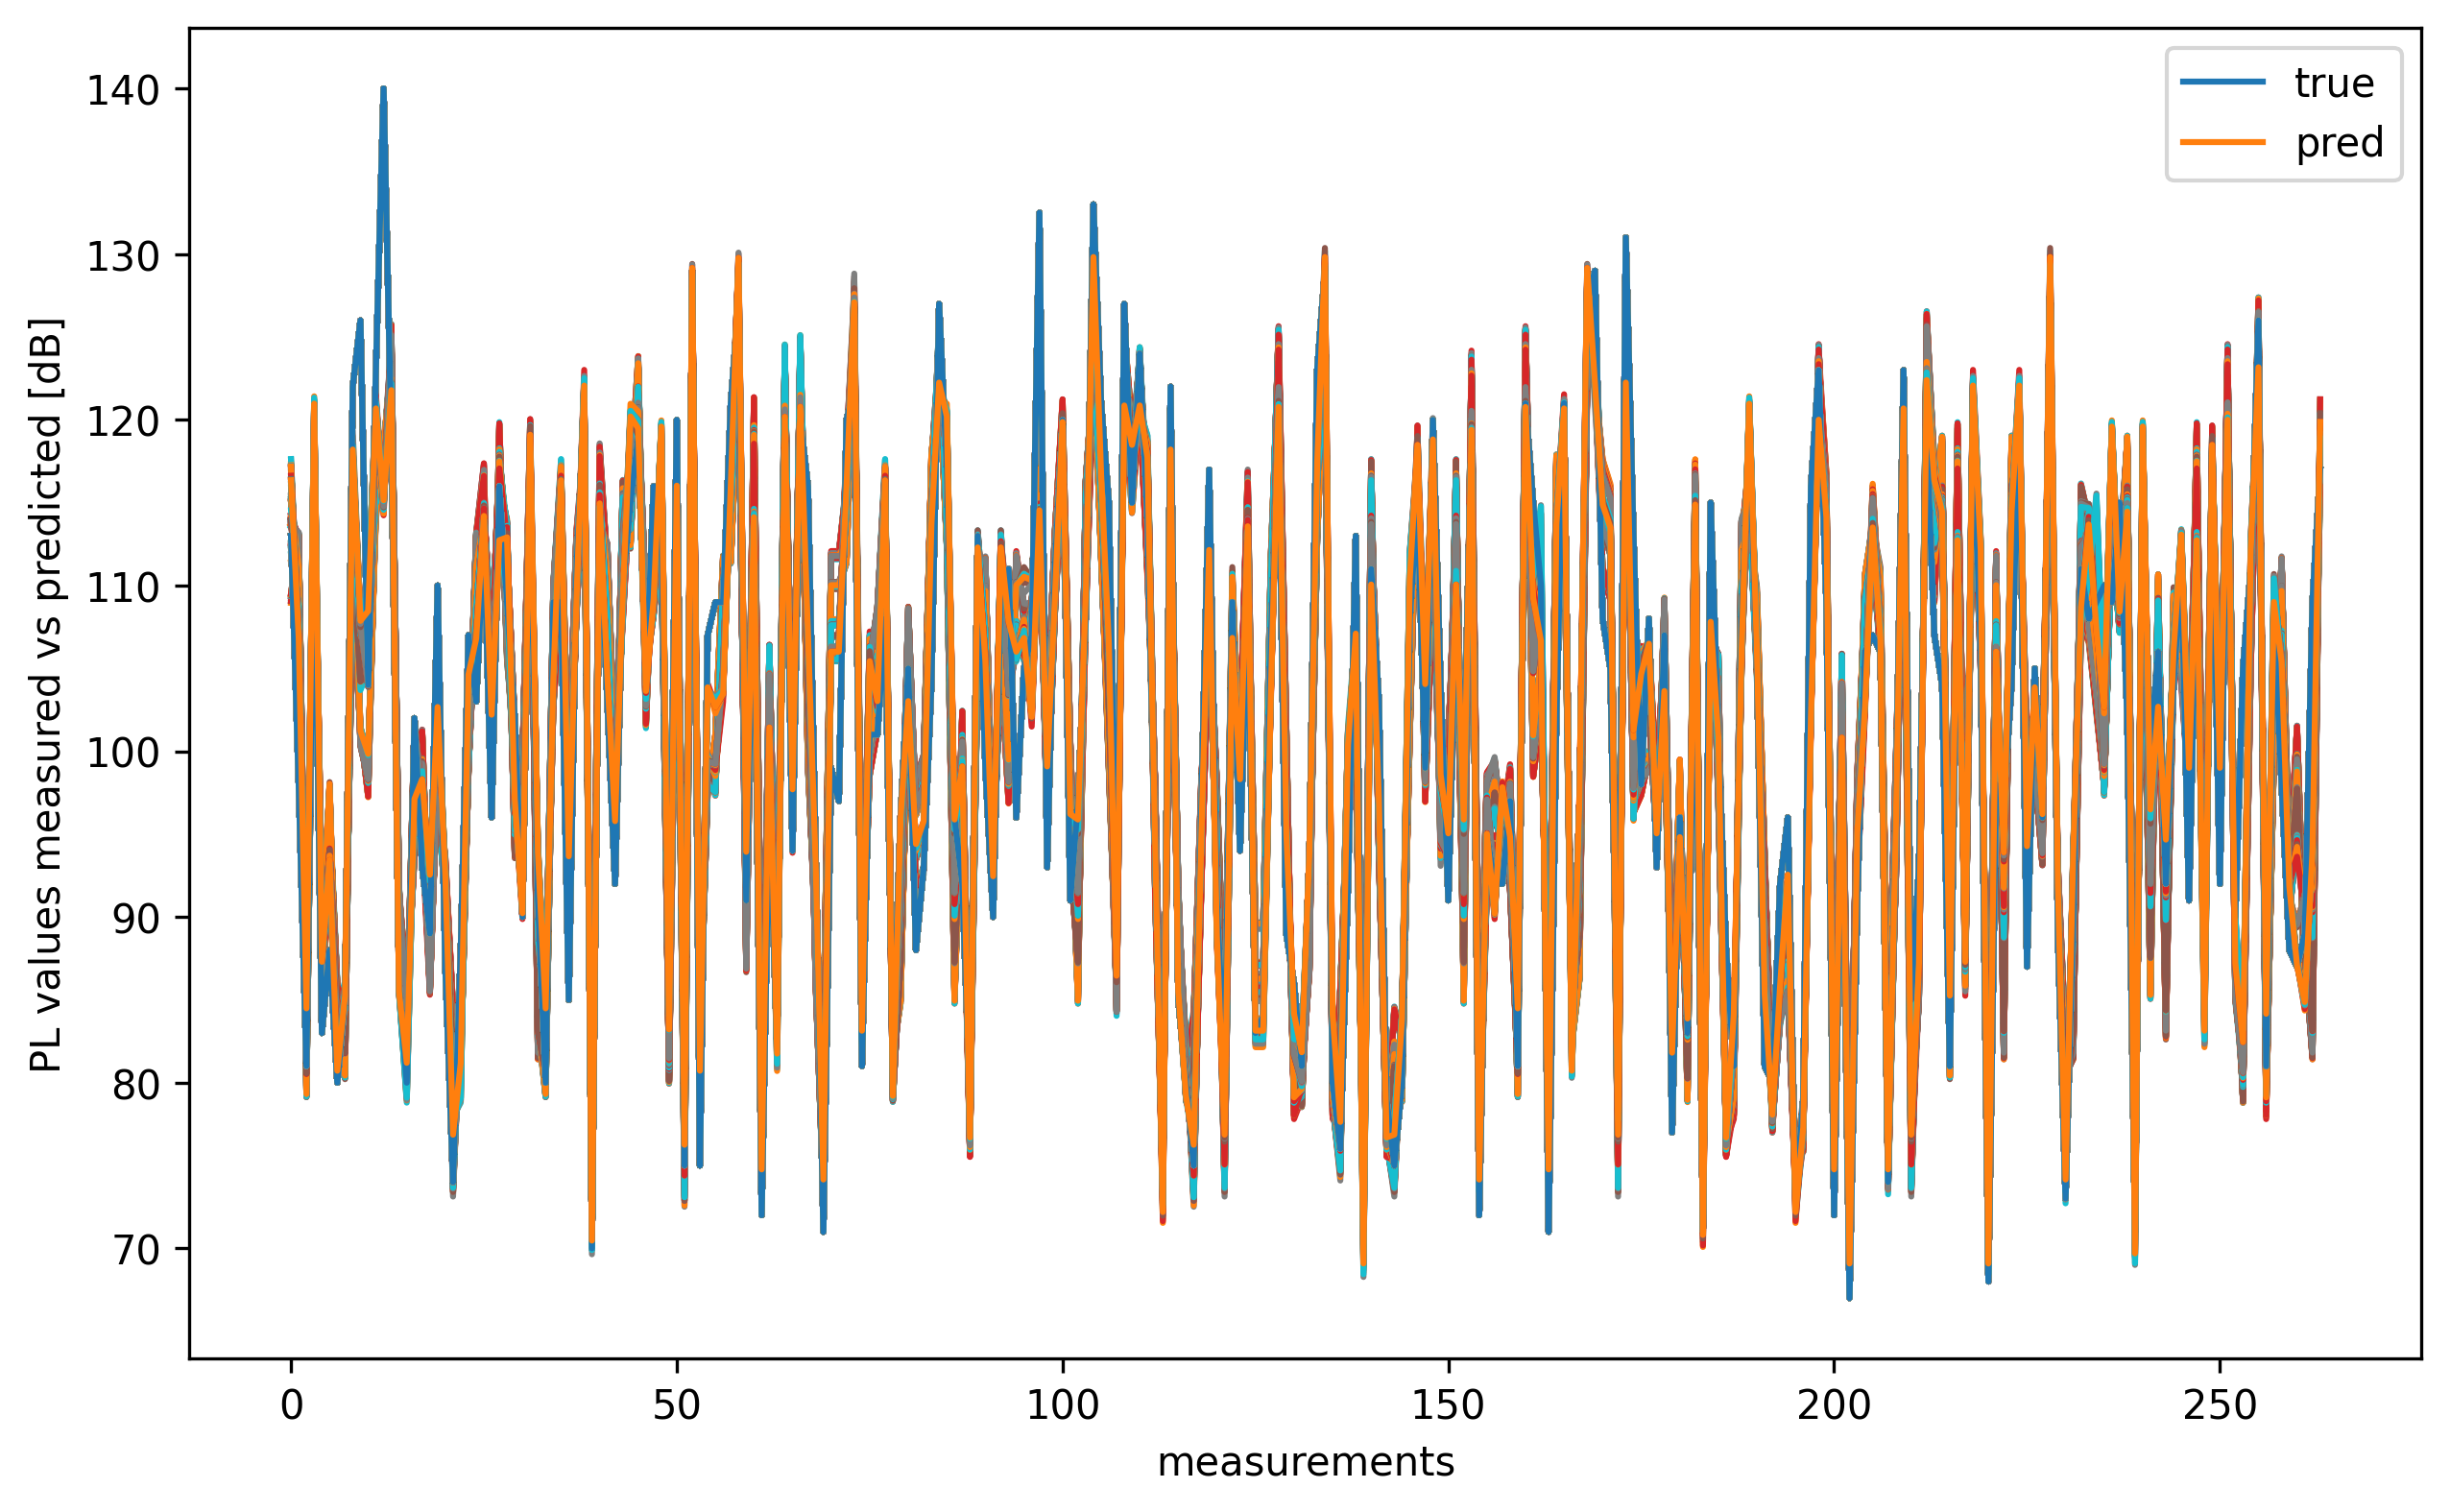

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[4,1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)
